In [13]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from sklearn import mixture
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import cluster
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report

In [9]:
trainingData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
testingData = ['ins8', 'ins9', 'n5','nfle16', 'nfle17', 'nfle18', 'nfle19','plm7', 'plm8', 'plm9','rbd18', 'rbd19', 'rbd20']
firstNumericCol = 6 # Includes age
#filepath = 'final_data/'
filepath = 'testingData/'
final = pd.DataFrame()

for dataset in testingData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(filepath + dataset + '.csv') # Create an untracked local data folder
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] -= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")

# Outlier Removal (Local Outlier Factor)
#keep_outliers = ['EMG']
n_neighbors = 20
LOF = neighbors.LocalOutlierFactor(n_neighbors = 20)
LOF.fit_predict(final.iloc[:, firstNumericCol:])
lof_factors = LOF.negative_outlier_factor_
final['lof'] = lof_factors
#outlierCutoff = -1000
quartiles = final['lof'].abs().quantile([0.25, 0.75])
#print(quartiles)
interQuartileRange = quartiles[0.75] - quartiles[0.25]
#outlierCutoff = -1 * (quartiles[0.75] + 1.5 * interQuartileRange)
outlierCutoff = -1000
outliers = final[final['lof'] <= outlierCutoff]
final = final[final['lof'] > outlierCutoff]
display(outliers)
#print(outlierCutoff)
#pd.DataFrame(lof_factors).to_csv('lof.csv')


#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.


,Unnamed: 0,Patient,epoch,Sleep Stage,condition,gender,age,beta_relative_power,alpha_relative_power,theta_relative_power,...,hf_ECG1-ECG2,lf/hf_ECG1-ECG2,breathingrate_ECG1-ECG2,bpm_PLETH,rmssd_PLETH,lf_PLETH,hf_PLETH,lf/hf_PLETH,breathingrate_PLETH,lof
284,284,ins8,284,S1,Insomnia,M,0.202456,0.732987,0.628773,0.097655,...,1.833481e+13,-0.495803,0.990582,0.383785,0.756149,2.611222e-01,5.930217e-01,-0.252370,0.000000,-7.711918e+04
502,502,ins8,502,S2,Insomnia,M,0.202456,0.327316,0.279049,0.453124,...,-1.973539e-01,-0.270542,8.316294,0.543298,-0.027177,5.334714e+23,1.174202e+24,-0.527884,0.666667,-1.611918e+04
793,793,ins8,793,S3,Insomnia,M,0.202456,-1.141136,-0.270081,-0.277158,...,3.498057e+12,273.626427,-0.085764,-1.241134,-1.178663,-3.606541e-01,-5.474528e-01,0.449273,0.333333,-3.519464e+05
832,832,ins8,832,W,Insomnia,M,0.202456,-0.796462,-0.716363,-0.940456,...,1.924174e+00,-0.495803,0.695272,0.297335,1.308182,7.882053e+23,6.758464e+23,0.161970,-0.666667,-1.336376e+04
137,137,ins9,137,S3,Insomnia,M,0.491953,-0.819913,-1.043296,-0.618924,...,3.049303e+42,-0.479395,-2.333333,-0.111445,0.604097,-5.020338e-01,-1.637474e-01,-0.539749,-0.666667,-5.541769e+41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,rbd20,95,S4,REM Behavior Disorder,M,0.491953,-1.500135,-0.745555,-0.611849,...,3.700589e-01,-0.400221,12.138367,0.982899,-0.701959,-8.063710e-01,1.759173e+21,-0.968127,-0.050402,-8.745432e+03
418,418,rbd20,418,S3,REM Behavior Disorder,M,0.491953,-0.805120,-0.898959,0.410234,...,2.202391e-01,-0.099134,-0.333333,-0.369761,-0.273408,4.069448e+16,5.359000e+13,734.859148,-1.347723,-1.530106e+03
876,876,rbd20,876,S3,REM Behavior Disorder,M,0.491953,-0.880522,-0.500950,0.492482,...,-6.103400e-02,-0.039147,-0.333333,1.143489,0.712239,1.767941e+28,9.470418e+28,-0.787233,-0.104673,-9.125071e+07
884,884,rbd20,884,S3,REM Behavior Disorder,M,0.491953,-1.080028,-0.796887,0.293738,...,1.532471e-01,-0.216895,-2.333333,1.305635,0.026168,2.100848e+20,1.783983e+20,0.172984,0.960595,-2.489986e+04


Encoding completed.
Dataset successfully exported!


In [4]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))
correlationFeatureRemoval.to_csv('finalTesting.csv')
# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()

NameError: name 'final' is not defined

In [60]:
trainingData = pd.read_csv('finalTraining.csv')
correlationFeatureRemoval = trainingData
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_dataTr = correlationFeatureRemoval[top_5_cols]
top_10_dataTr = correlationFeatureRemoval[top_10_cols]
top_20_dataTr = correlationFeatureRemoval[top_20_cols]
top_30_dataTr = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous 

                          0         1
9         EMG_epochEnergy_x  0.280823
2      theta_relative_power  0.280821
3              perm_entropy  0.280821
4                      katz  0.280821
8                   EOG_ECB  0.280821
10       EMG_5Highest5Sec_y  0.280821
11          EMG_epochEnergy  0.280821
1      alpha_relative_power  0.280821
18              rmssd_PLETH  0.280787
23                      lof  0.280756
20                 hf_PLETH  0.280705
17                bpm_PLETH  0.279828
21              lf/hf_PLETH  0.279490
19                 lf_PLETH  0.279342
13          rmssd_ECG1-ECG2  0.278684
12            bpm_ECG1-ECG2  0.275803
14             hf_ECG1-ECG2  0.274035
15          lf/hf_ECG1-ECG2  0.269590
16  breathingrate_ECG1-ECG2  0.157059
5                  SAO2_avg  0.116873
0                       age  0.061120
22      breathingrate_PLETH  0.048513
7                   above70  0.033267
6                   above90  0.027070


In [61]:
testingData = pd.read_csv('finalTesting.csv')
correlationFeatureRemoval = testingData
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_dataTe = correlationFeatureRemoval[top_5_cols]
top_10_dataTe = correlationFeatureRemoval[top_10_cols]
top_20_dataTe = correlationFeatureRemoval[top_20_cols]
top_30_dataTe = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

                          0         1
20              rmssd_PLETH  0.302996
25                      lof  0.302850
10                  EOG_ECB  0.302842
1       beta_relative_power  0.302842
12        EMG_epochEnergy_y  0.302842
11       EMG_5Highest5Sec_x  0.302842
13          EMG_epochEnergy  0.302842
5                      katz  0.302842
4              perm_entropy  0.302842
3      theta_relative_power  0.302842
2      alpha_relative_power  0.302842
15          rmssd_ECG1-ECG2  0.302302
19                bpm_PLETH  0.301973
22                 hf_PLETH  0.301963
9                   EOG_VAV  0.301521
14            bpm_ECG1-ECG2  0.300996
23              lf/hf_PLETH  0.297717
21                 lf_PLETH  0.297216
17          lf/hf_ECG1-ECG2  0.296310
16             hf_ECG1-ECG2  0.295556
18  breathingrate_ECG1-ECG2  0.143204
24      breathingrate_PLETH  0.106670
6                  SAO2_min  0.055495
0                       age  0.055022
7                   above90  0.027700
8           

/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous 

In [62]:
print(top_20_dataTr)


       Unnamed: 0 Patient  epoch  sleep_stage gender  rbd  ins  nfle  plm  \
0               0  nfle10      0          0.0      M  0.0  0.0   1.0  0.0   
1               1  nfle10      1          0.0      M  0.0  0.0   1.0  0.0   
2               2  nfle10      2          0.0      M  0.0  0.0   1.0  0.0   
3               3  nfle10      3          0.0      M  0.0  0.0   1.0  0.0   
4               4  nfle10      4          0.0      M  0.0  0.0   1.0  0.0   
...           ...     ...    ...          ...    ...  ...  ...   ...  ...   
19562       19562      n2    850          1.0      M  0.0  0.0   0.0  0.0   
19563       19563      n2    851          1.0      M  0.0  0.0   0.0  0.0   
19564       19564      n2    852          1.0      M  0.0  0.0   0.0  0.0   
19565       19565      n2    853          1.0      M  0.0  0.0   0.0  0.0   
19566       19566      n2    854          1.0      M  0.0  0.0   0.0  0.0   

       EMG_epochEnergy_x  ...  hf_PLETH  bpm_PLETH  lf/hf_PLETH  lf_PLETH  

In [63]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size 
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=False) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.sigmoid(out)
        out = self.fc_2(out) # final output
        out = self.drop(out)
        
        return out

In [64]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    numFeatures = X_train.shape[2]
    print("Top "+ str(numFeatures) + " LSTM")
    
    train_loss_values = []
    test_loss_values = []
    final_preds = 0
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        train_loss_values.append(loss.item())
        optimiser.step() #backpropagation
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        if (epoch == (n_epochs - 1)):
            final_preds = test_preds
        test_loss = loss_fn(test_preds, y_test)
        test_loss_values.append(test_loss.item())
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))
    
    return train_loss_values, test_loss_values, final_preds

Top 5 LSTM
Epoch: 0, train loss: 1.90221, test loss: 1.83348
Epoch: 100, train loss: 1.63310, test loss: 1.66486
Epoch: 200, train loss: 1.58825, test loss: 1.65937
Epoch: 300, train loss: 1.49334, test loss: 1.69447
Epoch: 400, train loss: 1.32113, test loss: 1.77948
Epoch: 500, train loss: 1.24746, test loss: 1.81768
Epoch: 600, train loss: 1.22992, test loss: 1.85874
Epoch: 700, train loss: 1.21190, test loss: 1.89493
Epoch: 800, train loss: 1.20809, test loss: 1.93173
Epoch: 900, train loss: 1.20370, test loss: 1.97045


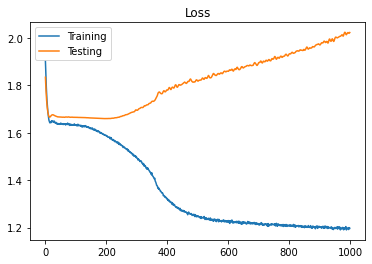

In [76]:
#Top 5
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 6 # 5+1 for unknown 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Data
train_input = torch.tensor(top_5_dataTr.iloc[:,9:].to_numpy()).float()
train_target = torch.tensor(top_5_dataTr.iloc[:,3].to_numpy()).float().type(torch.LongTensor)
test_input = torch.tensor(top_5_dataTe.iloc[:,9:].to_numpy()).float()
test_target = torch.tensor(top_5_dataTe.iloc[:,3].to_numpy()).float().type(torch.LongTensor)


train_input = torch.reshape(train_input,(train_input.shape[0], 1, 
                                       train_input.shape[1])).float()

test_input = torch.reshape(test_input,(test_input.shape[0], 1, 
                                       test_input.shape[1])).float()

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=train_input,
              y_train=train_target,
              X_test=test_input,
              y_test=test_target)

plt.title('Loss')
plt.plot(trainLoss, label = 'Training')
plt.plot(testLoss, label = 'Testing')
plt.legend()




In [77]:
target_names = ['W', 'S1', 'S2', 'S3', 'S4', 'R']
print(classification_report(test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

              precision    recall  f1-score   support

           W       0.47      0.87      0.61      2598
          S1       0.00      0.00      0.00       621
          S2       0.36      0.07      0.12      3545
          S3       0.00      0.00      0.00      1397
          S4       0.23      0.90      0.36      1400
           R       0.00      0.00      0.00      1579

    accuracy                           0.34     11140
   macro avg       0.18      0.31      0.18     11140
weighted avg       0.25      0.34      0.23     11140



/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top 10 LSTM
Epoch: 0, train loss: 1.82429, test loss: 1.67554
Epoch: 100, train loss: 1.15767, test loss: 1.69700
Epoch: 200, train loss: 1.12209, test loss: 2.06847
Epoch: 300, train loss: 1.11044, test loss: 2.21878
Epoch: 400, train loss: 1.10659, test loss: 2.29471
Epoch: 500, train loss: 1.10582, test loss: 2.31762
Epoch: 600, train loss: 1.10654, test loss: 2.32950
Epoch: 700, train loss: 1.10149, test loss: 2.26896
Epoch: 800, train loss: 1.09351, test loss: 2.24704
Epoch: 900, train loss: 1.08569, test loss: 2.24646


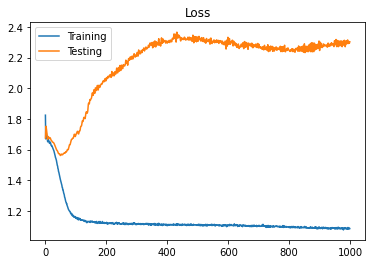

In [82]:
#Top 10
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 10
hidden_size = 2
num_layers = 1 

num_classes = 6 # 5+1 for unknown 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


#Data
train_input = torch.tensor(top_10_dataTr.iloc[:,9:].to_numpy()).float()
train_target = torch.tensor(top_10_dataTr.iloc[:,3].to_numpy()).float().type(torch.LongTensor)
test_input = torch.tensor(top_10_dataTe.iloc[:,9:].to_numpy()).float()
test_target = torch.tensor(top_10_dataTe.iloc[:,3].to_numpy()).float().type(torch.LongTensor)


train_input = torch.reshape(train_input,(train_input.shape[0], 1, 
                                       train_input.shape[1])).float()

test_input = torch.reshape(test_input,(test_input.shape[0], 1, 
                                       test_input.shape[1])).float()

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=train_input,
              y_train=train_target,
              X_test=test_input,
              y_test=test_target)

plt.title('Loss')
plt.plot(trainLoss, label='Training')
plt.plot(testLoss, label='Testing')
plt.legend()

In [83]:
target_names = ['W', 'S1', 'S2', 'S3', 'S4', 'R']
print(classification_report(test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

              precision    recall  f1-score   support

           W       0.42      0.91      0.58      2598
          S1       0.00      0.00      0.00       621
          S2       0.07      0.01      0.02      3545
          S3       0.00      0.00      0.00      1397
          S4       0.12      0.41      0.18      1400
           R       0.00      0.00      0.00      1579

    accuracy                           0.27     11140
   macro avg       0.10      0.22      0.13     11140
weighted avg       0.14      0.27      0.16     11140



/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top 20 LSTM
Epoch: 0, train loss: 1.78213, test loss: 1.75811
Epoch: 100, train loss: 1.59632, test loss: 1.65432
Epoch: 200, train loss: 1.47639, test loss: 1.58158
Epoch: 300, train loss: 1.37877, test loss: 1.57220
Epoch: 400, train loss: 1.30114, test loss: 1.62873
Epoch: 500, train loss: 1.24658, test loss: 1.71337
Epoch: 600, train loss: 1.21838, test loss: 1.82486
Epoch: 700, train loss: 1.19516, test loss: 1.85627
Epoch: 800, train loss: 1.18208, test loss: 1.88652
Epoch: 900, train loss: 1.17411, test loss: 1.91067


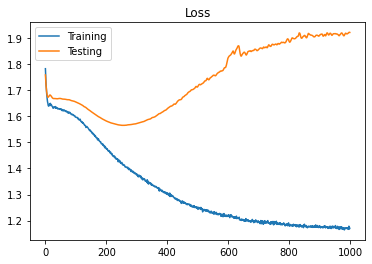

In [80]:
#Top 20
#Params
n_epochs = 1000
learning_rate = 0.001

input_size = 20
hidden_size = 2
num_layers = 1 

num_classes = 6 # 5+1 for unknown 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm = lstm.float()

loss_fn = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#Data
train_input = torch.tensor(top_20_dataTr.iloc[:,9:].to_numpy()).float()
train_target = torch.tensor(top_20_dataTr.iloc[:,3].to_numpy()).float().type(torch.LongTensor)
test_input = torch.tensor(top_20_dataTe.iloc[:,9:].to_numpy()).float()
test_target = torch.tensor(top_20_dataTe.iloc[:,3].to_numpy()).float().type(torch.LongTensor)


train_input = torch.reshape(train_input,(train_input.shape[0], 1, 
                                       train_input.shape[1])).float()

test_input = torch.reshape(test_input,(test_input.shape[0], 1, 
                                       test_input.shape[1])).float()

#Training Loop
trainLoss, testLoss, final_preds = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=train_input,
              y_train=train_target,
              X_test=test_input,
              y_test=test_target)

plt.title('Loss')
plt.plot(trainLoss, label='Training')
plt.plot(testLoss, label='Testing')
plt.legend()

In [81]:
target_names = ['W', 'S1', 'S2', 'S3', 'S4', 'R']
print(classification_report(test_target.detach().numpy(), np.argmax(final_preds.detach().numpy(),1), target_names = target_names))

              precision    recall  f1-score   support

           W       0.65      0.53      0.58      2598
          S1       0.00      0.00      0.00       621
          S2       0.06      0.00      0.01      3545
          S3       0.00      0.00      0.00      1397
          S4       0.15      0.94      0.26      1400
           R       0.10      0.00      0.00      1579

    accuracy                           0.24     11140
   macro avg       0.16      0.25      0.14     11140
weighted avg       0.20      0.24      0.17     11140



/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josh/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
